In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
data_dir = "../dataset-original"

In [6]:
img_height, img_width = 160, 160

# To Reproduce result
tf.random.set_seed(42)
np.random.seed(42)

# Why 42?
# "Answer to the Ultimate Question of Life" from The Hitchhiker's Guide to the Galaxy

num_epochs = 400

In [7]:
ImageDataGenerator?

Init signature:
ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None,
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.

Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
recommended for new code. Prefer loading images with
`tf.keras.utils.image_dataset_from_directory` and transforming the output
`tf.data.Dataset` with preprocessing layers. For more information, see the
tutoria

### Preprocessing

    Rescale: Normalize pixel values to the range [0, 1] to aid model convergence

### Augmentation

    1) Shear Range: Introduce deformations up to 20 degrees to introduce deformations for robustness such as shaky pictures.
    
    2) Zoom Range: Randomly zoom in/out by 20% to simulate varying object scales in images.
       
    3) Horizontal Flip: Enable random horizontal flipping for different camera angle variations.

    4) Vertical Flip: Enable random vertical flipping for different camera angle variations.
       
    5) Rotation Range: Rotate images up to 40 degrees to mimic real world camera angle variations. 
    
    6) Width Shift Range: Shift images horizontally to mimic real world camera angle variations.  
    
    7) Height Shift Range: Shift images vertically to mimic real world camera angle variations.  
    
    8) Brightness Range: Adjust brightness between 0.5 and 1.5 times to adapt to diverse lighting conditions.  
    
    9) Channel Shift Range: Shift color channels to introduce color variations for robustness (different camera specification such as RGB vs SRGB.

In [8]:
#The reason for rescaling is to converge to a satisfactory solution using reasonable time and resource.

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,          
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=20,
    validation_split=0.2
)

In [9]:
ImageDataGenerator.flow_from_directory?

Signature:
ImageDataGenerator.flow_from_directory(
    self,
    directory,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset=None,
    interpolation='nearest',
    keep_aspect_ratio=False,
)
Docstring:
Takes the path to a directory & generates batches of augmented data.

Args:
    directory: string, path to the target directory. It should contain
      one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
      inside each of the subdirectories directory tree will be included
      in the generator. See [this script](
      https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
      for more details.
    target_size: Tuple of integers `(height, width)`, defaults to `(256,
      256)`. The dimensions to which all images found will be resized.
    color_mode: One of 

In [10]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

# Why categorical?
# Determines the type of label arrays that are returned:
#       - "categorical" will be 2D one-hot encoded labels

Found 2024 images belonging to 6 classes.


In [11]:
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

Found 503 images belonging to 6 classes.


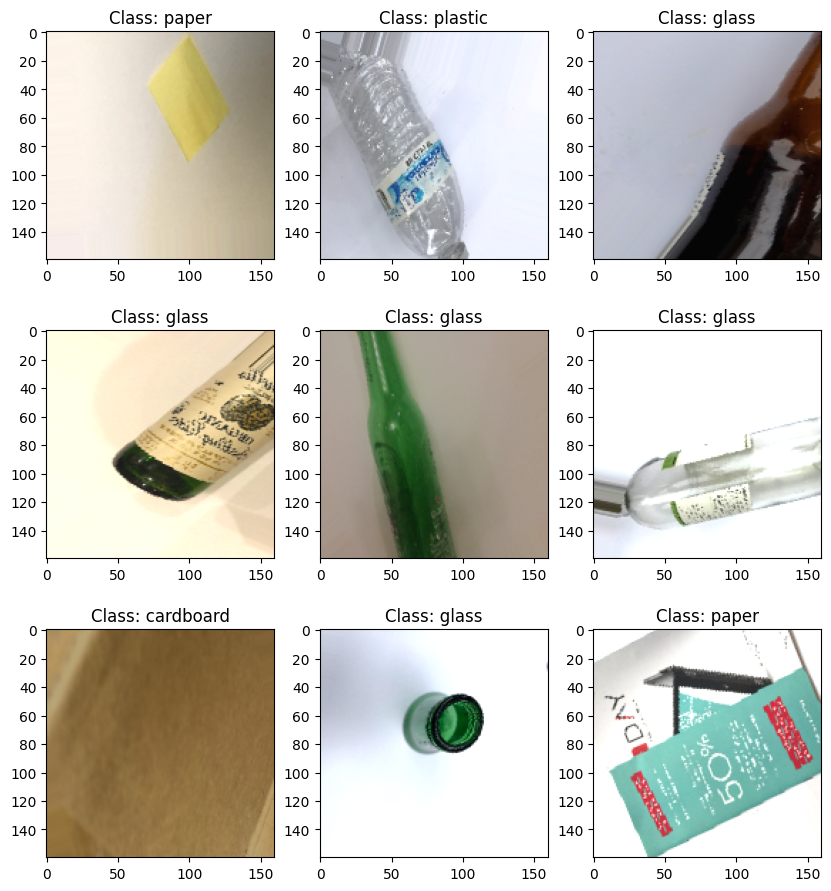

In [12]:
sample_images, sample_labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

fig, axs = plt.subplots(3, 3, figsize=(10, 11))

for i, ax in enumerate(axs.flat):
   ax.imshow(sample_images[i])
   class_index = np.argmax(sample_labels[i])
   class_name = class_names[class_index]  
   ax.set_title(f"Class: {class_name}")

plt.show()

In [13]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = np.unique(train_generator.classes)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_generator.classes)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_names)
print(class_weight_dict)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
{0: 1.04437564499484, 1: 0.8412302576891105, 2: 1.0284552845528456, 3: 0.7086834733893558, 4: 0.8739205526770294, 5: 3.066666666666667}


####  Weightage during training

    1) Class 0 (Cardboard): Slightly up-weighted.  
    
    2) Class 1 (Glass): Down-weighted.  
    
    3) Class 2 (Metal): Slightly up-weighted.  
    
    4) Class 3 (Paper): Down-weighted.

    5) Class 4 (Plastic): Down-weighted.
    
    6) Class 5 (Trash): Significantly up-weighted.  

In [14]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
inputs = Input(shape=(img_height, img_width, 3))
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = True

82420632/82420632 [==============================] - 14s 0us/step


In [16]:
x = GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(base_model.input, outputs)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [18]:
checkpoint_dir = './efficient_net_v2s_checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}.h5')

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

callbacks = [model_checkpoint_callback, early_stopping_callback]

In [19]:
history = model.fit(
    train_generator,
    epochs=400,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/400
64/64 [==============================] - ETA: 0s - loss: 2.8485 - accuracy: 0.1877
Epoch 1: val_accuracy improved from -inf to 0.20080, saving model to ./efficient_net_v2s_checkpoints\model_checkpoint_01.h5
64/64 [==============================] - 308s 4s/step - loss: 2.8485 - accuracy: 0.1877 - val_loss: 1.7854 - val_accuracy: 0.2008
Epoch 2/400
64/64 [==============================] - ETA: 0s - loss: 2.6075 - accuracy: 0.2347
Epoch 2: val_accuracy improved from 0.20080 to 0.29225, saving model to ./efficient_net_v2s_checkpoints\model_checkpoint_02.h5
64/64 [==============================] - 282s 4s/step - loss: 2.6075 - accuracy: 0.2347 - val_loss: 1.7308 - val_accuracy: 0.2922
Epoch 3/400
64/64 [==============================] - ETA: 0s - loss: 2.4368 - accuracy: 0.2648
Epoch 3: val_accuracy improved from 0.29225 to 0.34592, saving model to ./efficient_net_v2s_checkpoints\model_checkpoint_03.h5
64/64 [==============================] - 279s 4s/step - loss: 2.4368 - accura

In [20]:
import pickle 

history_file_path = 'efficient_net_v2s_training_history.pkl'

with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

print("Training history saved to:", history_file_path)

Training history saved to: efficient_net_v2s_training_history.pkl


### Validation

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization, Flatten
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import pickle

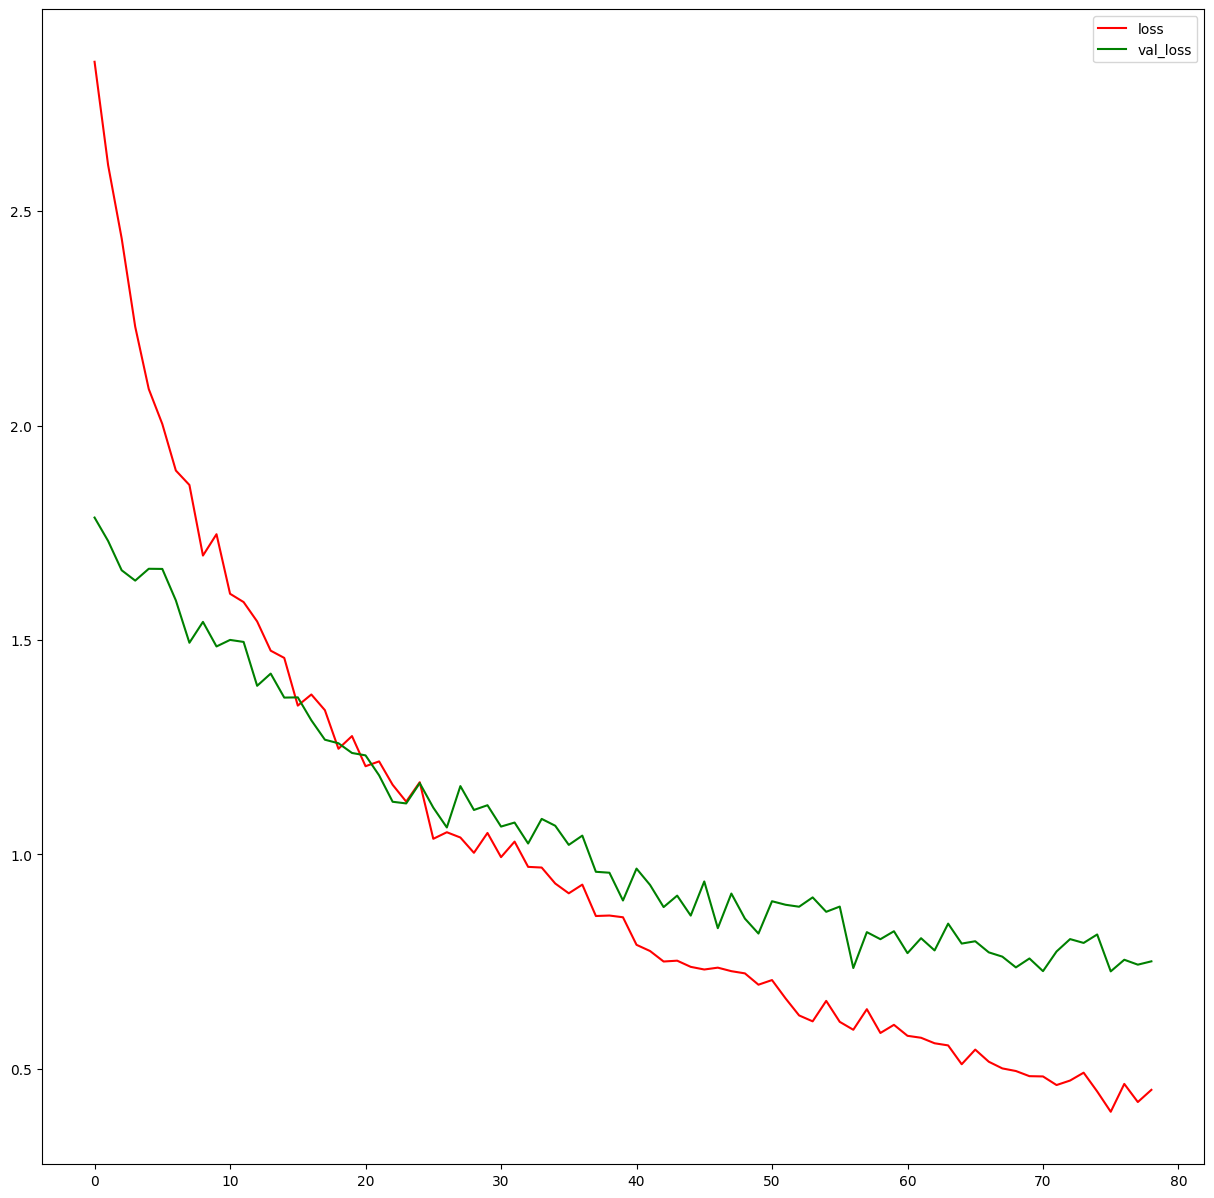

In [2]:
with open('efficient_net_v2s_training_history.pkl', 'rb') as file:
        loaded_history = pickle.load(file)

fig, ax = plt.subplots(figsize=(15, 15))
losses = pd.DataFrame(loaded_history)
losses[['loss','val_loss']].plot(color=['red', 'green'], ax=ax)
plt.show()

In [3]:
data_dir = "../dataset-original"

In [4]:
img_height, img_width = 160, 160
tf.random.set_seed(42)
np.random.seed(42)


validation_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,          
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=20,
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)

Found 503 images belonging to 6 classes.


In [5]:
class_names = list(validation_generator.class_indices.keys())
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [6]:
best_model_location = "./efficient_net_v2s_checkpoints/model_checkpoint_69.h5"

inputs = Input(shape=(img_height, img_width, 3))
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = True

x = GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
outputs = Dense(len(validation_generator.class_indices), activation='softmax')(x)
model = Model(base_model.input, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

model.load_weights(best_model_location)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 80, 80, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 80, 80, 24)   96          ['stem_conv[0][0]']          

In [7]:
predictions = model.predict(validation_generator)

16/16 [==============================] - 59s 3s/step


In [8]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

In [9]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

In [10]:
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy of the best model: {:.2f}%".format(accuracy * 100))

Accuracy of the best model: 78.13%


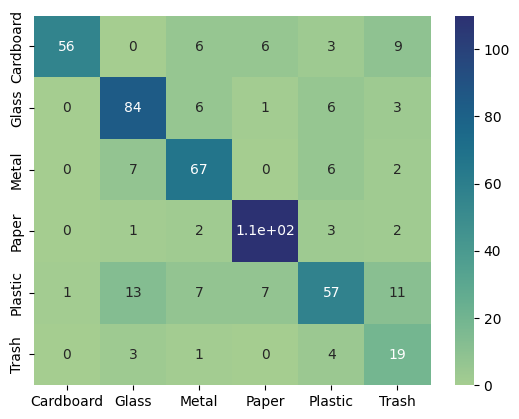

In [11]:
import seaborn as sns

class_details = {
    0: "Cardboard",
    1: "Glass",
    2: "Metal",
    3: "Paper",
    4: "Plastic",
    5: "Trash"
}
df_cm = pd.DataFrame(conf_matrix)
sns.heatmap(df_cm, annot=True, xticklabels=class_details.values(), yticklabels=class_details.values(), cmap='crest')
plt.show()

In [12]:
classification_scores = classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys(), output_dict=True)
classification_scores_df = pd.DataFrame(classification_scores).transpose()
classification_scores_df

,precision,recall,f1-score,support
cardboard,0.982456,0.700000,0.817518,80.000000
glass,0.777778,0.840000,0.807692,100.000000
metal,0.752809,0.817073,0.783626,82.000000
paper,0.887097,0.932203,0.909091,118.000000
plastic,0.721519,0.593750,0.651429,96.000000
trash,0.413043,0.703704,0.520548,27.000000
accuracy,0.781312,0.781312,0.781312,0.781312
macro avg,0.755784,0.764455,0.748317,503.000000
weighted avg,0.801591,0.781312,0.783882,503.000000


1/1 [==============================] - 0s 65ms/step


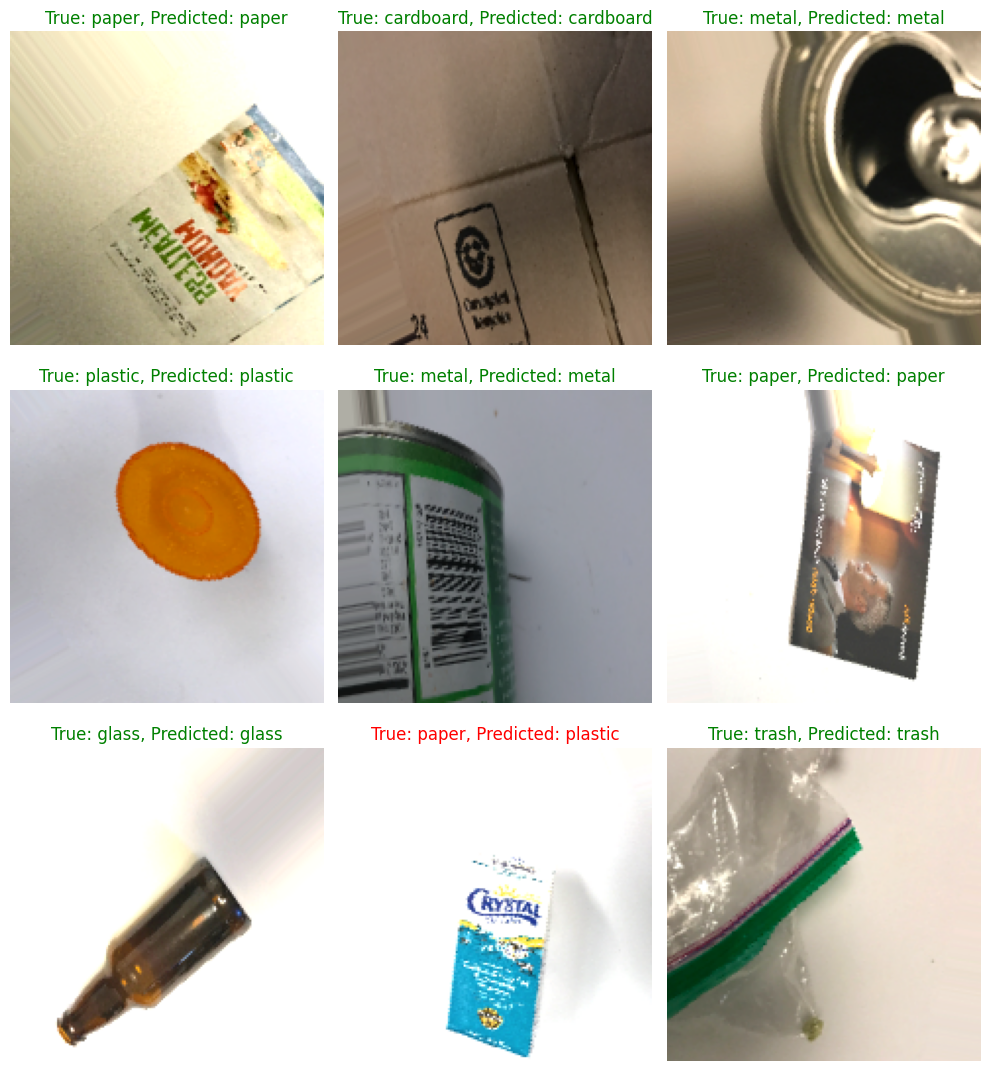

In [13]:
num_samples = 9
random_indices = np.random.choice(len(validation_generator), size=num_samples, replace=False)

sample_images = []
sample_labels = []

for idx in random_indices:
    batch = validation_generator[idx]
    image = batch[0][0]
    label_index = np.argmax(batch[1][0])
    sample_images.append(image)
    sample_labels.append(label_index)

class_names = list(validation_generator.class_indices.keys())

# Plot images with true and predicted labels
fig, axs = plt.subplots(3, 3, figsize=(10, 11))

for ax, image, true_label_index in zip(axs.flat, sample_images, sample_labels):
    true_label_name = class_names[true_label_index]
    predicted_label_probs = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_label_index = np.argmax(predicted_label_probs)
    predicted_label_name = class_names[predicted_label_index]
    label_color = 'green' if predicted_label_index == true_label_index else 'red'
    
    ax.imshow(image)
    ax.set_title(f"True: {true_label_name}, Predicted: {predicted_label_name}", color=label_color)
    ax.axis('off')

plt.tight_layout()
plt.show()


### Real World Test

1/1 [==============================] - 0s 46ms/step


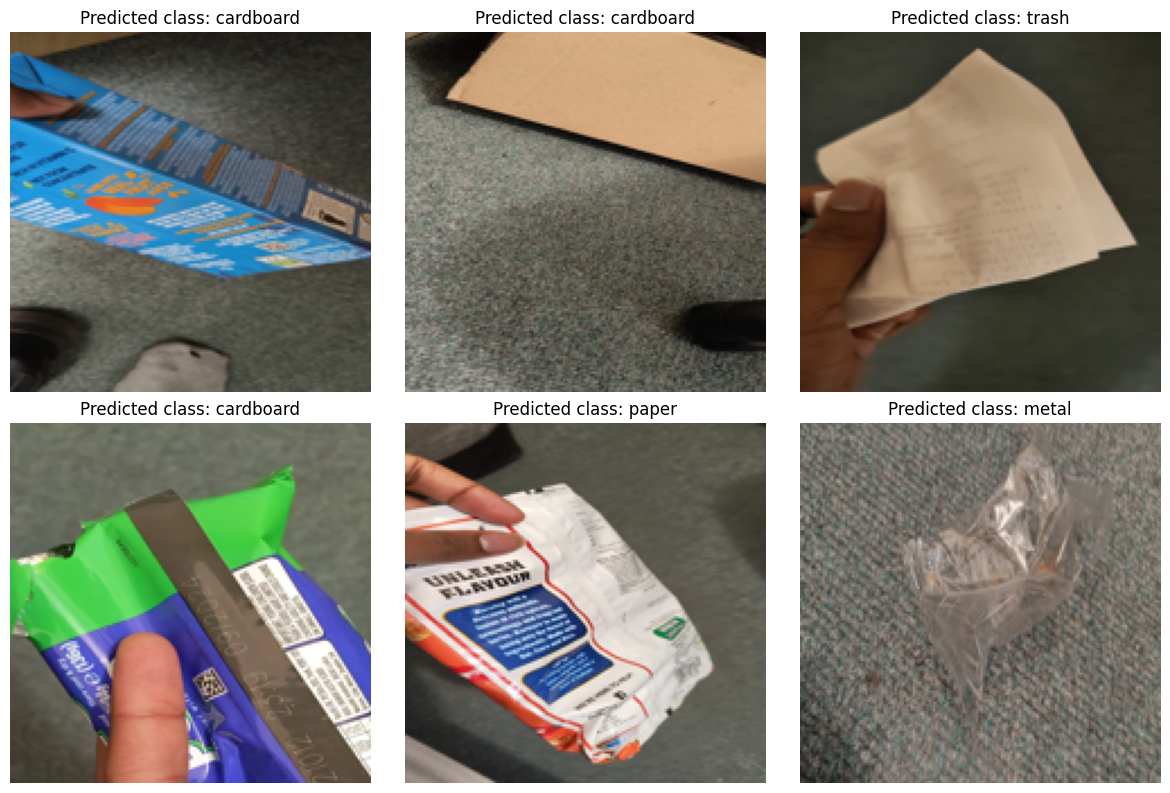

In [14]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

folder_path = '../live_samples/'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, filename in enumerate(os.listdir(folder_path)[:6]):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img = img.resize((160, 160))
        img_array = np.array(img, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalize pixel values to [0, 1] as float32

        predictions = model.predict(img_array)

        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = class_names[predicted_class_index]

        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(f"Predicted class: {predicted_class_name}")
        ax.axis('off')

plt.tight_layout()
plt.show()
